In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

mpl.rc('font', family='serif', size=15)
mpl.rc('text', usetex=True)

out_dir = '../assets/output/'

In [2]:
def newton(f, Jf, x0, eps=1e-5, max_iter=100, print_flag=False):
    x, fx = x0.copy(), f(x0)
    if (print_flag):
        df = pd.DataFrame(columns=[f'x{i}' for i in range(x.size)] +
                          [f'f{i}(x)' for i in range(x.size)] + [f'Δx{i}' for i in range(x.size)])
        df.loc[0] = x0[:, 0].tolist() + fx[:, 0].tolist() + [np.nan] * x.size
    for k in range(max_iter):
        Jx = Jf(x)
        dx = la.solve(Jx, -fx)
        x += dx
        fx = f(x)
        if (print_flag):
            df.loc[k + 1] = x[:, 0].tolist() + fx[:, 0].tolist() + dx[:, 0].tolist()
        if la.norm(dx, np.inf) < eps:
            return x, df
    raise RuntimeError('Failed to converge.')


def f(X):
    x, y = X[0, 0], X[1, 0]
    return np.array([[x**2 + y**2 - 1], [x**3 - y]])


def Jf(X):
    x, y = X[0, 0], X[1, 0]
    return np.array([[2 * x, 2 * y], [3 * x**2, -1]])


x0 = np.array([[0.8], [0.6]])

x, df = newton(f, Jf, x0, print_flag=True)
df.to_csv(out_dir + 'newton.csv')
df

,x0,x1,f0(x),f1(x),Δx0,Δx1
0,0.800000,0.600000,0.000000e+00,-8.800000e-02,NaN,NaN
1,0.827049,0.563934,2.032384e-03,1.775770e-03,0.027049,-3.606557e-02
2,0.826032,0.563624,1.130462e-06,2.564199e-06,-0.001017,-3.107495e-04
3,0.826031,0.563624,1.266987e-12,2.555511e-12,-0.000001,4.854571e-07


,x,n=10,n=20,n=40,n=80,n=160
0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.7,1.522124,1.627369,1.650779,1.656046,1.657272
2,1.4,1.187216,1.459592,1.506833,1.514911,1.516473
3,2.1,0.848624,0.987615,1.012079,1.015218,1.015633
4,2.8,1.393152,1.703457,1.766233,1.776372,1.778156
5,3.5,0.843823,1.288093,1.361410,1.372504,1.374359
6,4.2,0.671457,1.003397,1.054699,1.061557,1.062506
7,4.9,1.129551,1.738468,1.842657,1.857998,1.860364
8,5.6,0.570765,1.141057,1.230804,1.243656,1.245603
9,6.3,0.510420,1.044895,1.126926,1.138275,1.139900


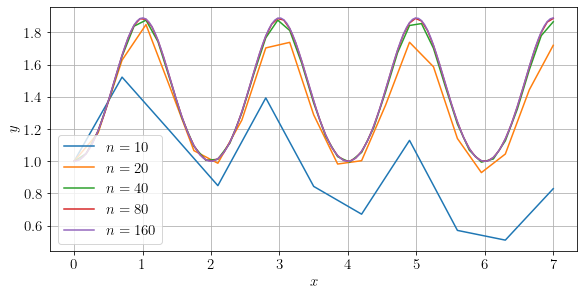

In [3]:
# Butcher tableau for modified Euler method, midpoint method, and Ralston method
MODIFIED_EULER = 2, [0.0, 1.0], [[0.0, 0.0], [1.0, 0.0]], [0.5, 0.5]
MIDPOINT = 2, [0.0, 0.5], [[0.0, 0.0], [0.5, 0.0]], [0.0, 1.0]
RALSTON = 2, [0.0, 2.0 / 3.0], [[0.0, 0.0], [2.0 / 3.0, 0.0]], [0.25, 0.75]


def runge_kutta(f, y0, begin, end, n, butcher=RALSTON, print_flag=False):
    s, a, b, c = butcher
    x = begin
    y = y0.copy()
    h = (end - begin) / n
    if (print_flag):
        df = pd.DataFrame(columns=['x'] + [f'y{i}' for i in range(y.size)])
        df.loc[0] = [x] + y0.tolist()
    k = np.zeros((s, y.size))
    for step in range(1, n + 1):
        for i in range(s):
            tmp = np.zeros(y.shape)
            for j in range(i):
                tmp += b[i][j] * k[i - 1]
            k[i] = f(x + a[i] * h, y + tmp * h)
        x += h
        for i in range(s):
            y += h * c[i] * k[i]
        if (print_flag): df.loc[step] = [x] + y.tolist()
    return y, df


def f(x, Y):
    y = Y[0]
    return np.array([y * np.sin(np.pi * x)])


y0 = np.array([1.0])
begin, end, n_list = 0.0, 7, [10, 20, 40, 80, 160]

df = pd.DataFrame({'x': np.linspace(begin, end, n_list[0] + 1)})

fig, ax = plt.subplots(figsize=(8, 4), constrained_layout=True)
for n in n_list:
    df_ = runge_kutta(f, y0, begin, end, n, print_flag=True)[1].rename(columns={'y0': f'n={n}'})
    df = pd.merge_asof(df, df_, on='x', direction='nearest')
    df_.plot(ax=ax, x='x', y=f'n={n}', label=f'$n={n}$')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.grid()
ax.legend()
fig.savefig('../assets/output/runge-kutta.pdf')
df.to_csv(out_dir + 'runge-kutta.csv')
df

,x,u|N=5,v|N=5,u|N=10,v|N=10,u|N=200,v|N=200
0,1.0,1.600000,1.200000,1.600000,1.200000,1.600000,1.200000
1,2.0,1.024566,1.266344,1.004766,1.266320,0.999487,1.266315
2,3.0,0.640912,1.336601,0.613859,1.336585,0.606801,1.336585
3,4.0,0.391211,1.410773,0.364035,1.410784,0.357123,1.410793
4,5.0,0.232862,1.488894,0.209135,1.488941,0.203277,1.488963
5,6.0,0.135138,1.571024,0.116183,1.571114,0.111668,1.571150


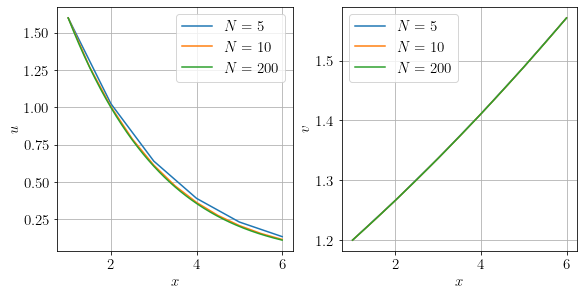

In [4]:
def f(x, Y):
    u, v = Y[0], Y[1]
    return np.array(
        [0.09 * u * (1 - u / 20) - 0.45 * u * v, 0.06 * v * (1 - v / 15) - 0.001 * u * v])


u0, v0 = 1.6, 1.2
y0 = np.array([u0, v0])
begin, end, n_list = 1.0, 6.0, [5, 10, 200]

df = pd.DataFrame({'x': np.linspace(begin, end, n_list[0] + 1)})

fig, ax = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)
for n in n_list:
    df_ = runge_kutta(f, y0, begin, end, n, butcher=MODIFIED_EULER, print_flag=True)[1].rename(columns={'y0': f'u|N={n}','y1': f'v|N={n}'})
    df = pd.merge_asof(df,
                        df_,
                        on='x',
                        direction='nearest')
    df_.plot(ax=ax[0], x='x', y=f'u|N={n}', label=f'$N={n}$')
    df_.plot(ax=ax[1], x='x', y=f'v|N={n}', label=f'$N={n}$')
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$u$')
ax[0].grid()
ax[0].legend()
ax[1].set_xlabel(r'$x$')
ax[1].set_ylabel(r'$v$')
ax[1].grid()
ax[1].legend()
fig.savefig('../assets/output/euler.pdf')
df.to_csv(out_dir + 'euler.csv')
df